In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

2025-01-11 11:46:50.158531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 11:46:50.177711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736581610.198686   26573 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736581610.204985   26573 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 11:46:50.227914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.keras.backend.set_floatx("float64")

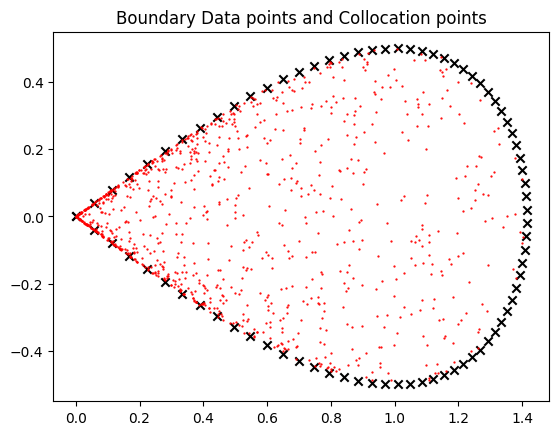

I0000 00:00:1736581688.384084   26573 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6062 MB memory:  -> device: 0, name: NVIDIA RTX A5000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# .......................................................................
## We solve Grad-Shafranov for Soloviev equilibria parametrized following
## Deriaz et al. paper .................................................
#.......... this is a funny drop-shape like equilibrium .....................
# .....................................................................

### data generation on boundary ..............
n_bc = 1
n_data_per_bc = 80
theta = np.linspace(np.pi, 3*np.pi,n_data_per_bc)
pa = 0.5
#
x = np.sqrt(1 + 2*pa*np.cos(theta))
y = pa*np.sin(theta)

data = np.zeros([1, n_data_per_bc, 3])
data[0, :, 0] = x 
data[0, :, 1] = y
data[0, :, 2] = 0    
data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

# collocation points ............................
Nc = 1000
colloc = np.zeros([Nc, 2]) 
engine = qmc.LatinHypercube(d=2)
points = engine.random(n=Nc)

points[:, 0] = (points[:, 0]*2*np.pi  + np.pi)
# The power hereafter can be tuned between 0 and in order to localize more or less where you want ...
colloc[:, 0] = points[:, 1]**0.75 *np.sqrt(1 + np.cos( points[:, 0]))
colloc[:, 1] = points[:, 1]**0.75 * pa*np.sin(points[:, 0] )

#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])
#
plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=1.5, marker=".", c="r", label="CP")
plt.show()

#
x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [4]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=7, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [5]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 7, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601 (20.32 KB)

 Trainable params: 2,601 (20.32 KB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [6]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [7]:
# Residual equation .... see paper .....Soloviev-like ..
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = x*u_xx + x*u_yy - u_x + x*(x*x+1)
    retour = tf.reduce_mean(tf.square(F))
    return retour


In [8]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 2.10161501
  100, 0.34489202
  200, 0.19684149
  300, 0.15100658
  400, 0.11177157
  500, 0.06194310
  600, 0.02455578
  700, 0.01605440
  800, 0.01265562
  900, 0.01026063
 1000, 0.00825150
 1100, 0.00646980
 1200, 0.00487788
 1300, 0.00348921
 1400, 0.00234515
 1500, 0.00149601
 1600, 0.00095909
 1700, 0.00067454
 1800, 0.00053540
 1900, 0.00045957
 2000, 0.00040867
 2100, 0.00036884
 2200, 0.00033528
 2300, 0.00030605
 2400, 0.00028019
 2500, 0.00025709
 2600, 0.00023633
 2700, 0.00021758
 2800, 0.00020059
 2900, 0.00018517
 3000, 0.00017113
 3100, 0.00015833
 3200, 0.00014665
 3300, 0.00013598
 3400, 0.00012623
 3500, 0.00011732
 3600, 0.00010917
 3700, 0.00010171
 3800, 0.00009488
 3900, 0.00008863
 4000, 0.00008291
 4100, 0.00007767
 4200, 0.00007303
 4300, 0.00006883
 4400, 0.00006495
 4500, 0.00006134
 4600, 0.00005825
 4700, 0.00005516
 4800, 0.00005243
 4900, 0.00004986
 5000, 0.00004766
 5100, 0.00004543
 5200, 0.00004343
 5300, 0.00004154
 5400, 0.00003992
 5500, 0.0

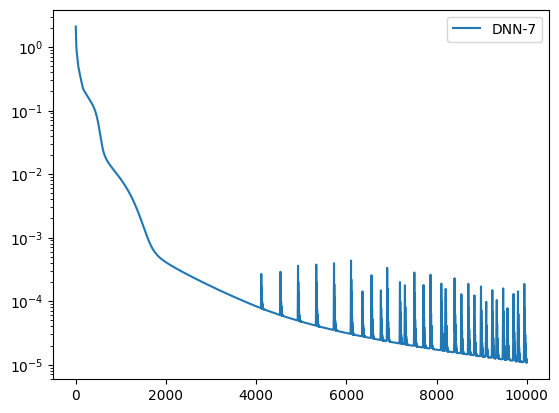

In [9]:
loss = 0
# epochs = 60000
epochs = 10000
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])
lp_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = L + l
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    l_values = np.append(l_values, l)
    L_values = np.append(L_values, L)
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.8f}")
        lp_values = np.append(lp_values, loss)

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

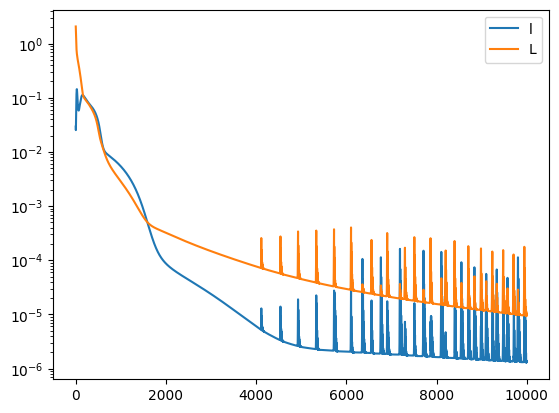

In [10]:
plt.semilogy(l_values, label="l")
plt.semilogy(L_values, label="L")
plt.legend()


n = 200
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])



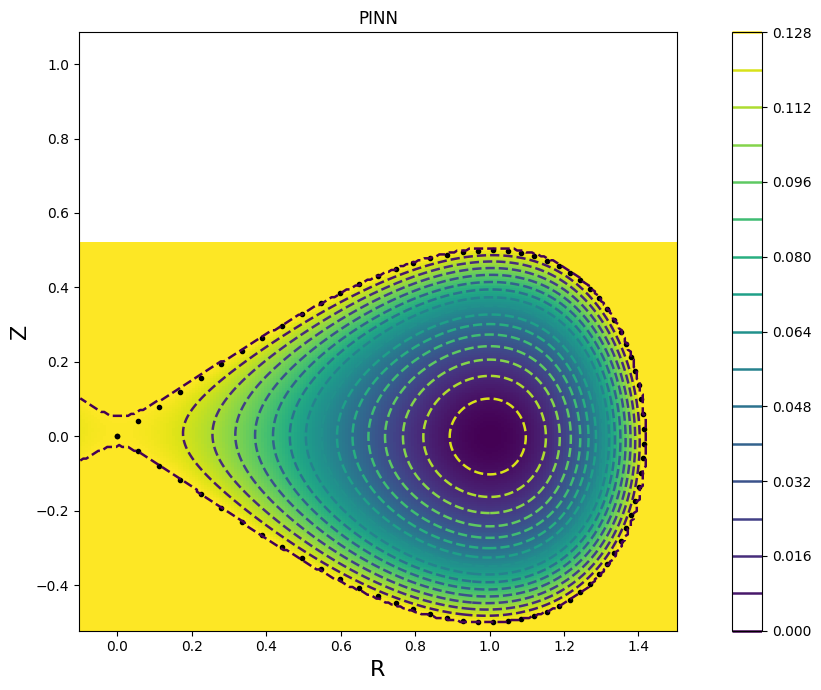

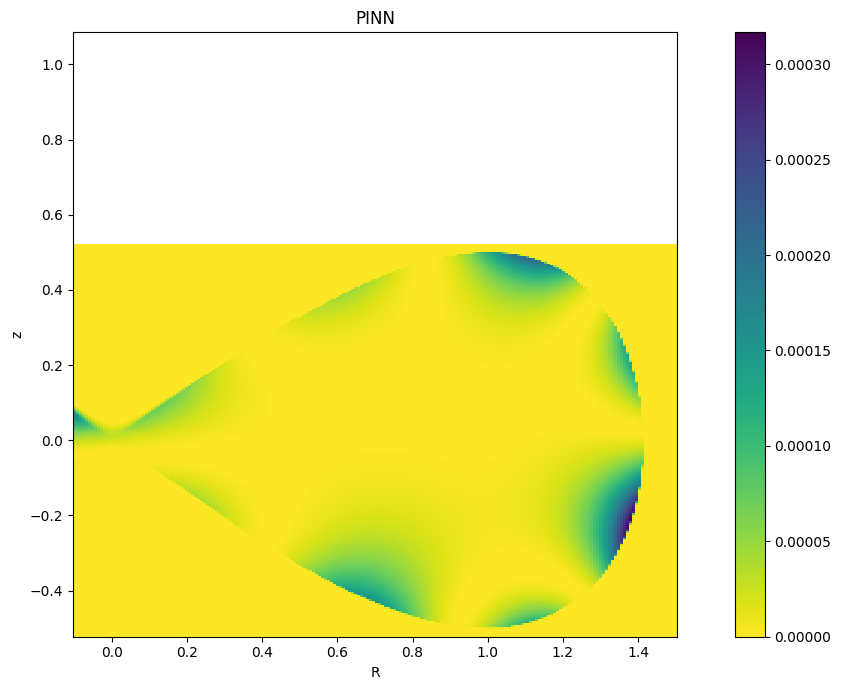

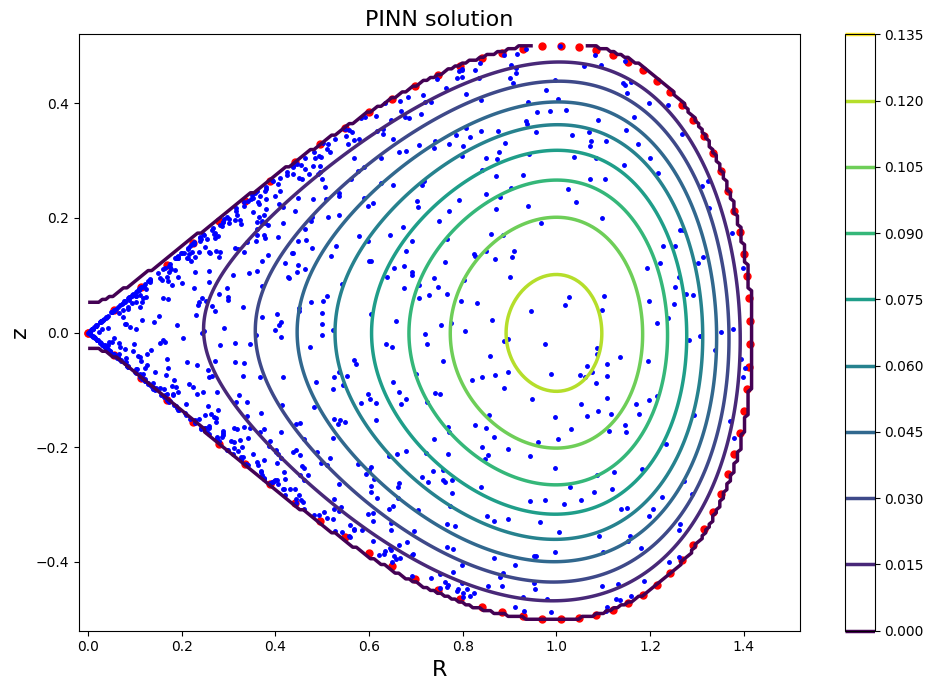

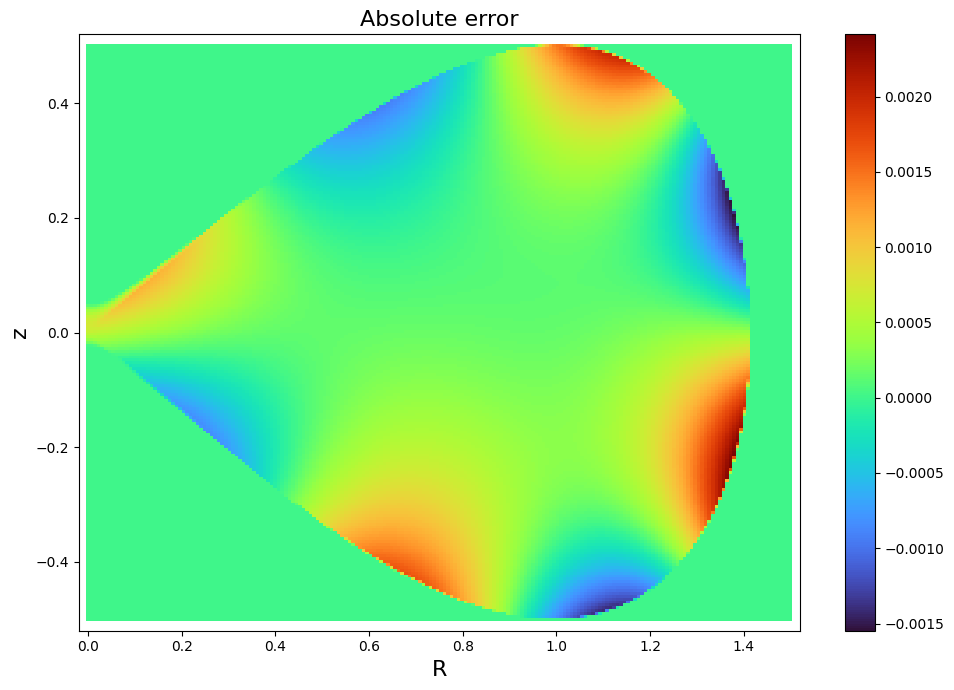

In [11]:
### plotting the results ....
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
X = np.linspace(-0.1, +1.5, n)
Y = np.linspace(-0.52, +0.52, n)
X0, Y0 = np.meshgrid(X, Y)

X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# Predicted solution .....
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
S2[S2 < 0] = 0.00000000000000000000
plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
plt.contour(X0, Y0, S2,15,linestyles='dashed',linewidths=1.8)
plt.colorbar(pad=-0.25)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="k", label="BDP")
plt.xlabel("R",fontsize=16)
plt.ylabel("Z",fontsize=16)
plt.xlim(-0.1, 1.6)
plt.ylim(-0.52, 0.52)
plt.title("PINN")
plt.tight_layout()
plt.axis("square")

plt.show()
#

plt.figure("", figsize=(14, 7))

# Exact solution .......
TT = 1/8*(1 - 4*Y0**2 - (2*(X0-1) + (X0-1)**2)**2) 
TT = 1/2*(pa**2 - Y0**2 - (2*(X0-1) + (X0-1)**2)**2 /4) 
TT2 = TT
TT2[TT2 < 0] = 0.00000000000000000
# error ......
err=(TT2-S2)**2/0.135**2

plt.pcolormesh(X0, Y0, err, cmap="viridis_r")

#plt.pcolormesh(X0, Y0, TT2-S2, cmap="viridis_r")

#plt.scatter(colloc[:, 0], colloc[:, 1], s=15.5, marker=".", c="r", label="CP")
#plt.scatter(data[:, 0], data[:, 1], marker=".", c="k", label="BDP")
#plt.contour(X0, Y0, TT2-S2,21)
plt.colorbar(pad=-0.25)
plt.xlabel("R")
plt.ylabel("z")
plt.xlim(0., 1.5)
plt.ylim(-0.5, 0.5)
plt.title("PINN")
plt.tight_layout()
plt.axis("square")

plt.show()
#


### plotting
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(10, 7))
#
X = np.linspace(-0., +1.5, n)
Y = np.linspace(-0.5, +0.5, n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
S2[S2 < 0] = 0.00000000000000000000
#plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
#plt.contour(X0, Y0, S2,15,linestyles='dashed',linewidths=1.8)
plt.contour(X0, Y0, S2,10,linewidths=2.5)
plt.colorbar(pad=+0.05)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r",s=100, label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=25, marker=".", c="b", label="CP")
plt.xlabel("R",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-0.02, 1.52)
plt.ylim(-0.52, 0.52)
plt.title("PINN solution",fontsize=16)
plt.tight_layout()
#plt.axis("square")

plt.show()
#



plt.figure("", figsize=(10, 7))
TT = 1/8*(1 - 4*Y0**2 - (2*(X0-1) + (X0-1)**2)**2) 
TT2 = TT
TT2[TT2 < 0] = 0.00000000000000000
#err=(-TT2+S2)**2/0.128**2
err = S2 - TT2
plt.pcolormesh(X0, Y0, err,cmap="turbo")

#plt.pcolormesh(X0, Y0, TT2-S2, cmap="viridis_r")

#plt.scatter(colloc[:, 0], colloc[:, 1], s=15.5, marker=".", c="r", label="CP")
#plt.scatter(data[:, 0], data[:, 1], marker=".", c="k", label="BDP")
#plt.contour(X0, Y0, TT2-S2,21)
plt.colorbar(pad=+0.05)
plt.xlabel("R",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-0.02, 1.52)
plt.ylim(-0.52, 0.52)
plt.title("Absolute error",fontsize=16)
plt.tight_layout()
#plt.axis("square")

plt.show()
#






